#ANIKET NANDY
#015015
#AN EXPLORATORY STUDY ON SUPPLY CHAIN ANALYTICS

# Data Collection

#The dataset is downloaded from:
“https://www.kaggle.com/shashwatwork/dataco-smart-supply-chain-for-big-data-analysis”
#•	The dataset includes about 180k transactions from DataCo Global's supply chains over a three-year period.
#•	It contains 52 characteristics or columns.


### Importing all required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import datetime as dt
import calendar,warnings,itertools,matplotlib,keras,shutil
import tensorflow as tf
import statsmodels.api as sm
from datetime import datetime
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression,ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor,BaggingClassifier,ExtraTreesClassifier
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from sklearn.datasets import load_iris,make_regression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_ridge import KernelRidge
from keras import Sequential
from keras.layers import Dense
from IPython.core import display as ICD
# from tensorflow_core.estimator import inputs

#Hiding the warnings
warnings.filterwarnings('ignore') 


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
dataset=pd.read_csv("/content/gdrive/My Drive/python/dataset.csv",header= 0,encoding= 'unicode_escape')
dataset.head(5)# Checking 5 rows in dataset

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


# Data Cleaning

In [ ]:
dataset.shape

(180519, 53)

The total data set consists of 180519 records and 53 columns

In [ ]:
dataset.apply(lambda x: sum(x.isnull())) #Checking missing values

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


The data consists of some missing values from Customer Lname, Product Description, Order Zipcode and, Customer Zipcode which should be removed or replaced before proceeding with the analysis. And also, since there is a chance different customers might have the same first name or same last name a new column with ‘customer full name’ is created to avoid any ambiguities.

In [ ]:
# Adding first name and last name together to create new column
dataset['Customer Full Name'] = dataset['Customer Fname'].astype(str)+dataset['Customer Lname'].astype(str)

All the columns with null values are dropped

In [ ]:
data=dataset.drop(['Customer Email','Product Status','Customer Password','Customer Street','Customer Fname','Customer Lname',
           'Latitude','Longitude','Product Description','Product Image','Order Zipcode','shipping date (DateOrders)'],axis=1)
data.shape

(180519, 42)


There are 3 missing values in Customer Zipcode column. Since the missing values are just zip codes which are not very important these are replaced with zero before proceeding with data analysis.

In [ ]:
data['Customer Zipcode']=data['Customer Zipcode'].fillna(0)#Filling NaN columns with zero

# Data Visualisation

To find important parameters, data correlation is performed.

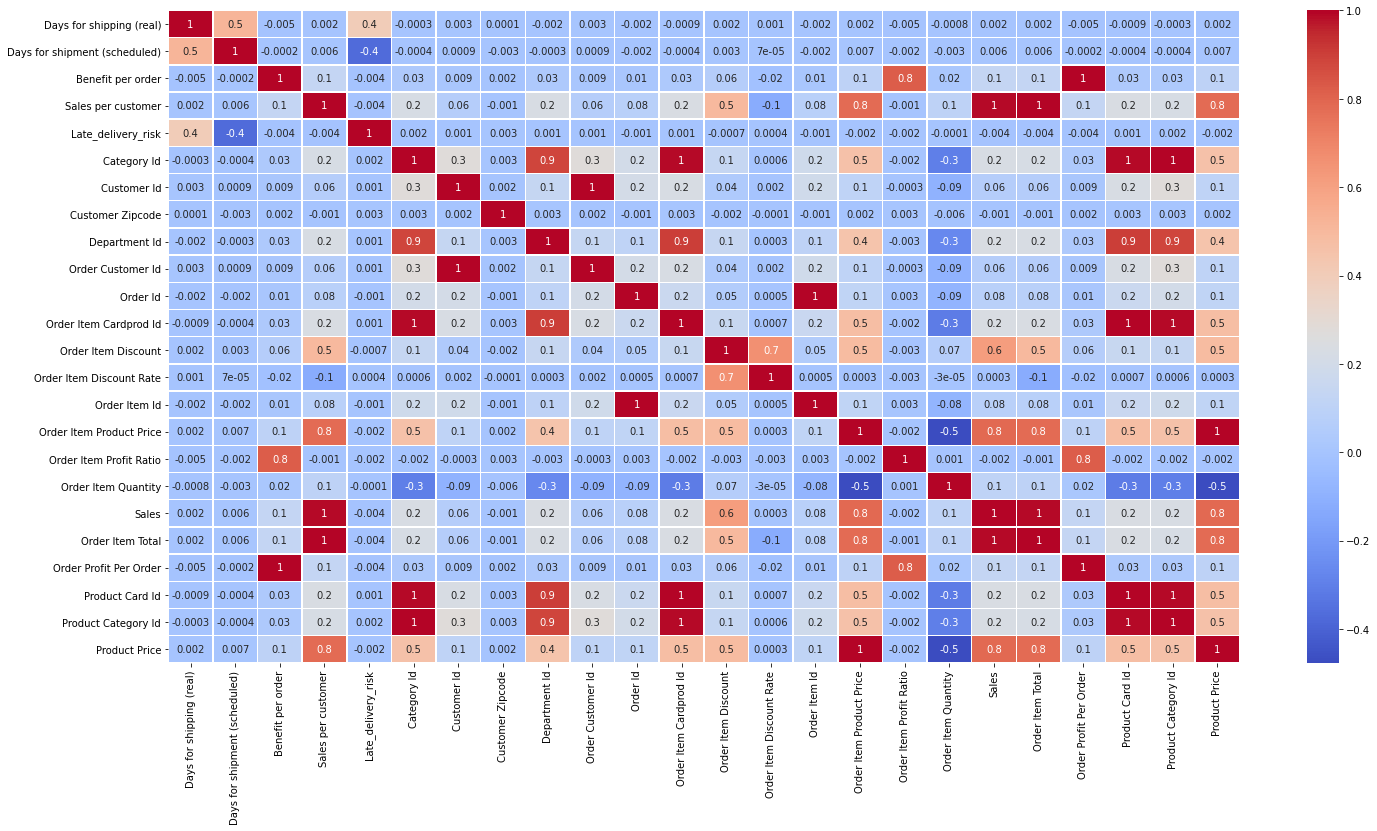

In [ ]:
fig, ax = plt.subplots(figsize=(24,12))         # figsize
sns.heatmap(data.corr(),annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm') # Heatmap for correlation matrix

We can observe that product price price has high correlation with Sales,Order Item Total.

As the data which is being used for analysis is related to Supply chain, it makes sense to find which region has most sales? It can be found by using groupby method which will segregate similar market regions together and add all sales for that particular region using 'sum' function.

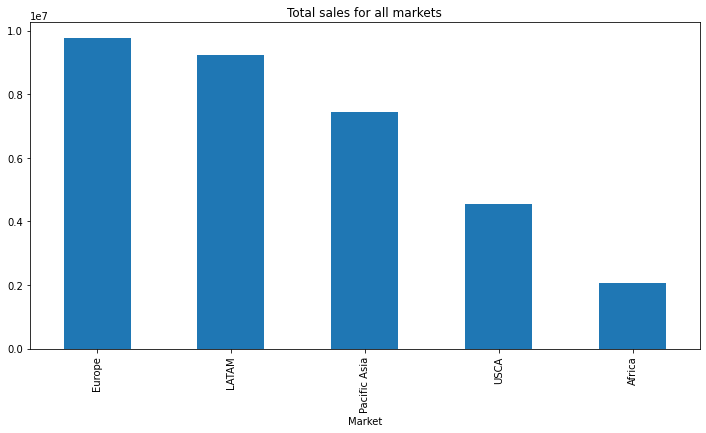

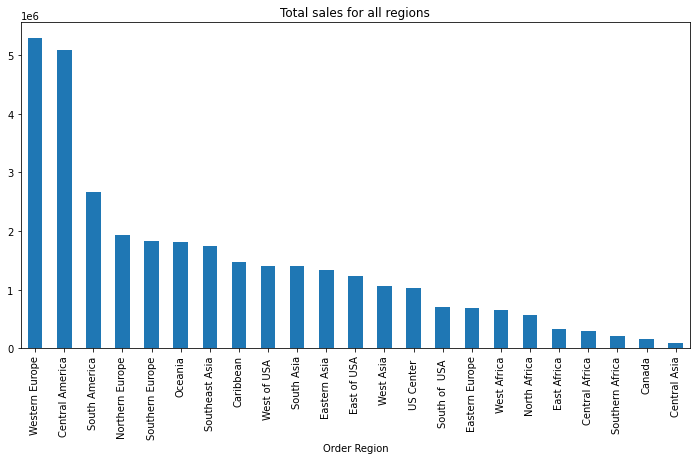

In [ ]:
market = data.groupby('Market') #Grouping by market
region = data.groupby('Order Region')
plt.figure(1)
market['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales for all markets")
plt.figure(2)
region['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales for all regions")

It could be seen from the graph that European market has the most number of sales whereas Africa has the least.In these markets western europe regions and central america recorded highest sales. 

Which catergory of products has highest sales?The same method can be followed here to see the product category with highest sales

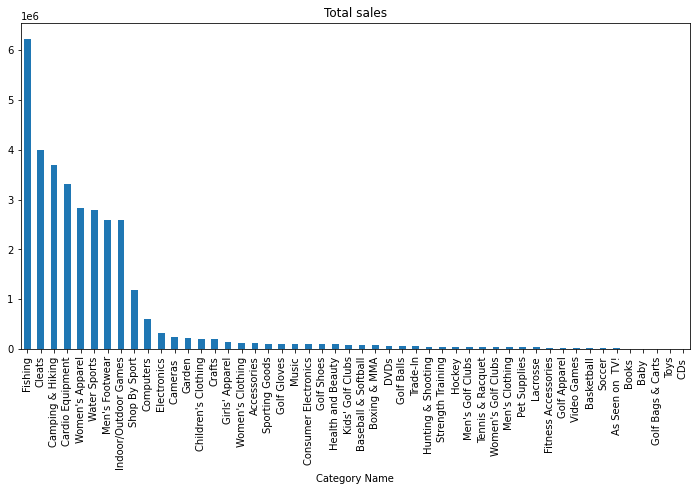

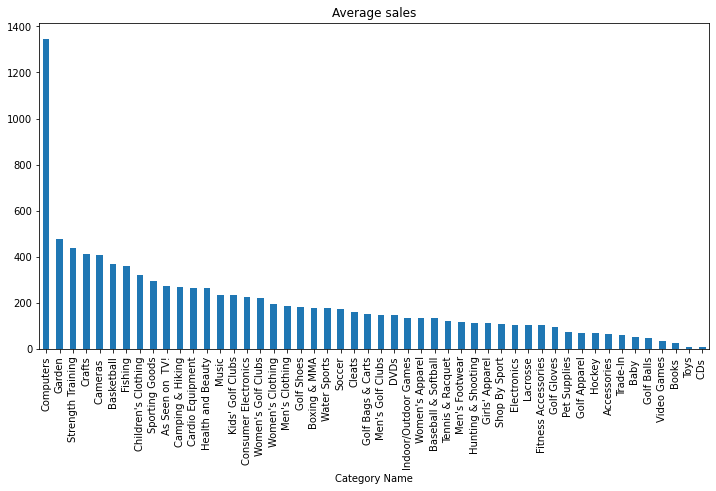

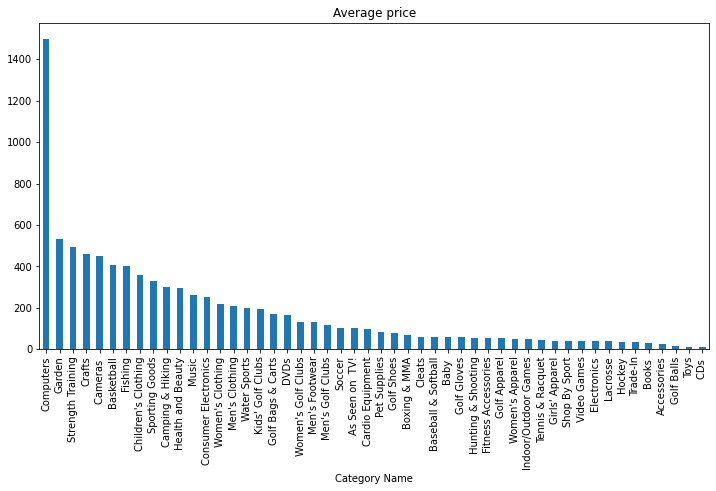

In [ ]:
#Grouping all categories
cat = data.groupby('Category Name')
plt.figure(1)
# Total sum of sales for all categories
cat['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales")
# Mean sales for all categories
plt.figure(2)
cat['Sales per customer'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Average sales")
plt.figure(3)
# Mean prices for all categories
cat['Product Price'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Average price")

As we can see from fig 1 that the fishing category had most number of sales followed by the Cleats.However it is suprising to see that top 7 products with highest price on average are the most sold products on average with computers having almost 1350 sales despite price being 1500$. 

Since correlation was high between Price and Sales it will be interesting to see how price is impacting the sales for all the products to see the trend.

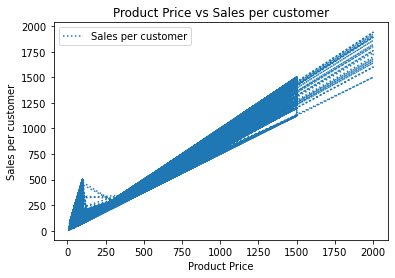

In [ ]:
data.plot(x='Product Price', y='Sales per customer',linestyle='dotted',
     markerfacecolor='blue', markersize=12) 
plt.title('Product Price vs Sales per customer')#title
plt.xlabel('Product Price')  # X-axis title
plt.ylabel('Sales per customer') # Y=axis title
plt.show()

It can be observed that prices has linear relation with sales. 





What is the purchase trend in week days,hours and months?

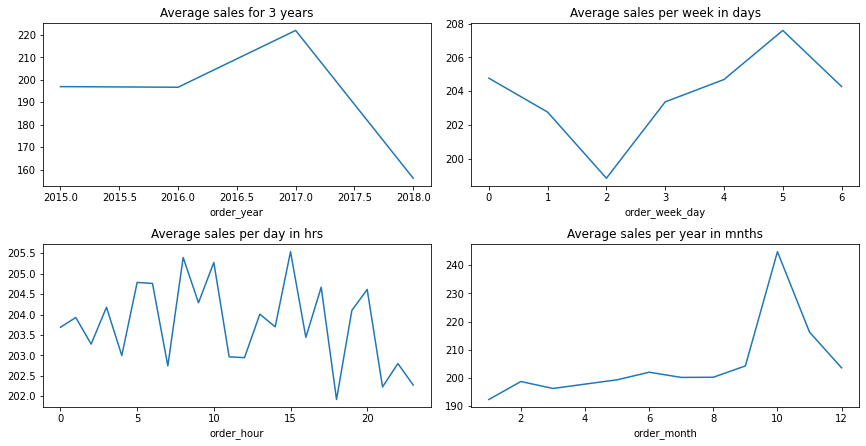

In [ ]:
plt.figure(figsize=(10,12))
plt.subplot(4, 2, 1)
quater= data.groupby('order_year')
quater['Sales'].mean().plot(figsize=(12,12),title='Average sales for 3 years')
plt.subplot(4, 2, 2)
days=data.groupby("order_week_day")
days['Sales'].mean().plot(figsize=(12,12),title='Average sales per week in days')
plt.subplot(4, 2, 3)
hrs=data.groupby("order_hour")
hrs['Sales'].mean().plot(figsize=(12,12),title='Average sales per day in hrs')
plt.subplot(4, 2, 4)
mnth=data.groupby("order_month")
mnth['Sales'].mean().plot(figsize=(12,12),title='Average sales per year in mnths')
plt.tight_layout()
plt.show()

How price is impacting sales, when and which products are having more sales are found.The most number of orders came in October followed by November, and orders for all other months are consistent.Highest number of orders are placed by customers in 2017. 
Saturday recorded highest number of average sales and wednesday with the least number of sales. The average sales are consistent throughout the day irrespective of time with std of 3.

It is also important to know what type of payment method is being preferred by people to buy all these products in all regions? It can be found using .unique() method to see different payment methods.

In [ ]:
data['Type'].unique()

array(['DEBIT', 'TRANSFER', 'CASH', 'PAYMENT'], dtype=object)

Which payment method is preferred the most by people in different regions?

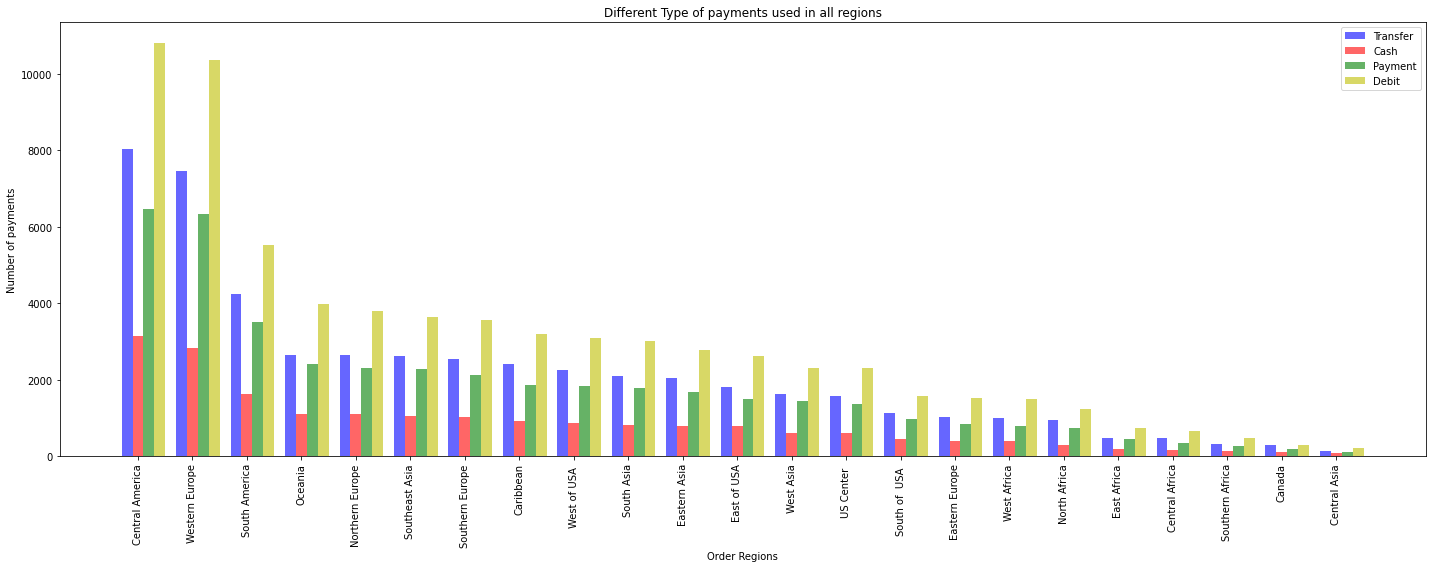

In [ ]:
#xyz = data.groupby('Type')
xyz1 = data[(data['Type'] == 'TRANSFER')]
xyz2= data[(data['Type'] == 'CASH')]
xyz3= data[(data['Type'] == 'PAYMENT')]
xyz4= data[(data['Type'] == 'DEBIT')]
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
count3=xyz3['Order Region'].value_counts()
count4=xyz4['Order Region'].value_counts()
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='b',label='Transfer')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='Cash')
type3=plt.bar(index+bar_width+bar_width,count3,bar_width,alpha=opacity,color='g',label='Payment')
type4=plt.bar(index+bar_width+bar_width+bar_width,count4,bar_width,alpha=opacity,color='y',label='Debit')
plt.xlabel('Order Regions')
plt.ylabel('Number of payments')
plt.title('Different Type of payments used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()


Debit type is most preferred payment method by people in all regions, Cash payment being the least preferred method.

Some products are having negative benefit per orders which indicates that the orders are generating loss of revenue to the company. Which products are these?

Total revenue lost with orders -3883547.345768667


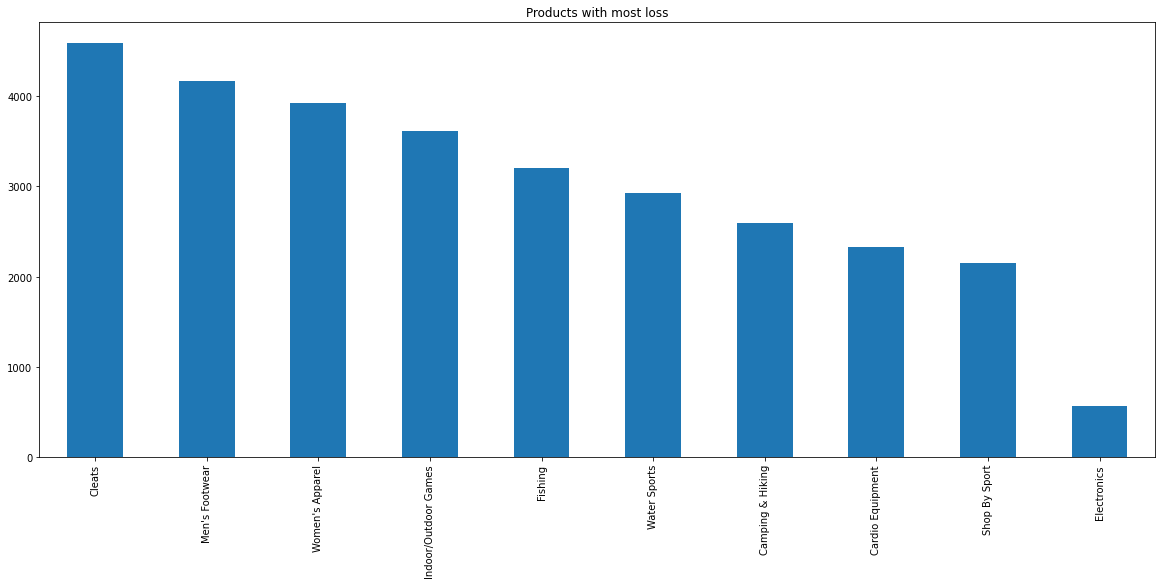

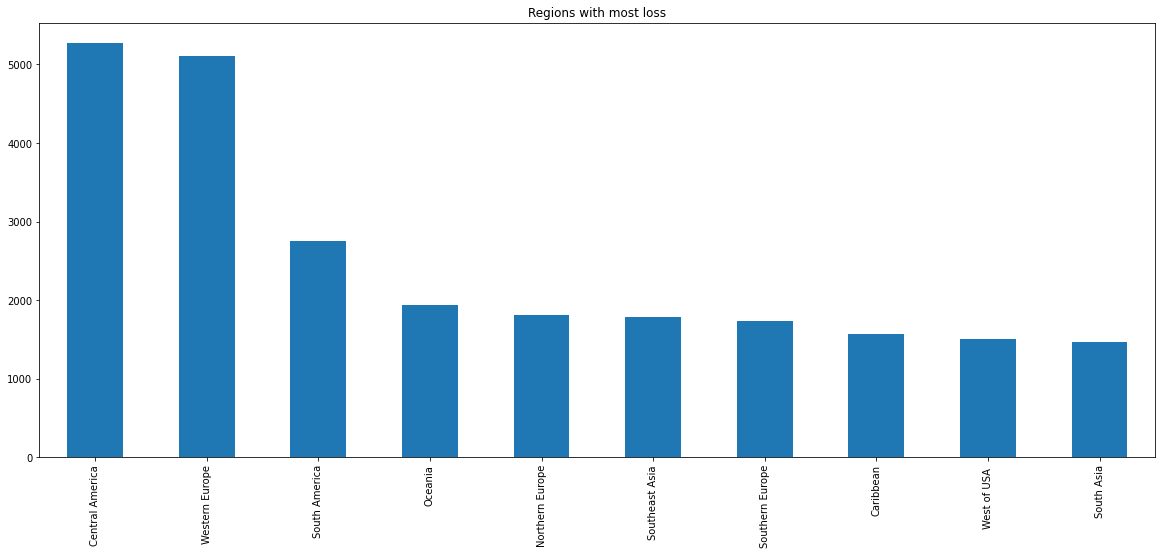

In [ ]:
loss = data[(data['Benefit per order']<0)]
#Plotting top 10 products with most loss
plt.figure(1)
loss['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Products with most loss")
plt.figure(2)
loss['Order Region'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Regions with most loss")
#Sum of total sales which are lost
print('Total revenue lost with orders',loss['Benefit per order'].sum())

The total loss sales are approximately 3.9 Millions which is an huge amount.It can be seen that Cleats is the category with most loss sales followed by Mens footwear.Most lost sales are happeing in central america and western europe region.This lost sales may have happened due to suspected frauds or late deliveries.

Finding which payment method is used to conduct frauds can be useful to  prevent fraud from happening in future

In [ ]:
#Checking type of payment used to conduct fraud other than Transfer
xyz = data[(data['Type'] != 'TRANSFER')&(data['Order Status'] == 'SUSPECTED_FRAUD')]
xyz['Order Region'].value_counts()

Series([], Name: Order Region, dtype: int64)

It can be clearly seen that there are no frauds conducted with DEBIT,CASH,PAYMENT methods so all the suspected fraud orders are made using wire transfer probably from abroad. 

Which region and what product is being suspected to the fraud the most? 

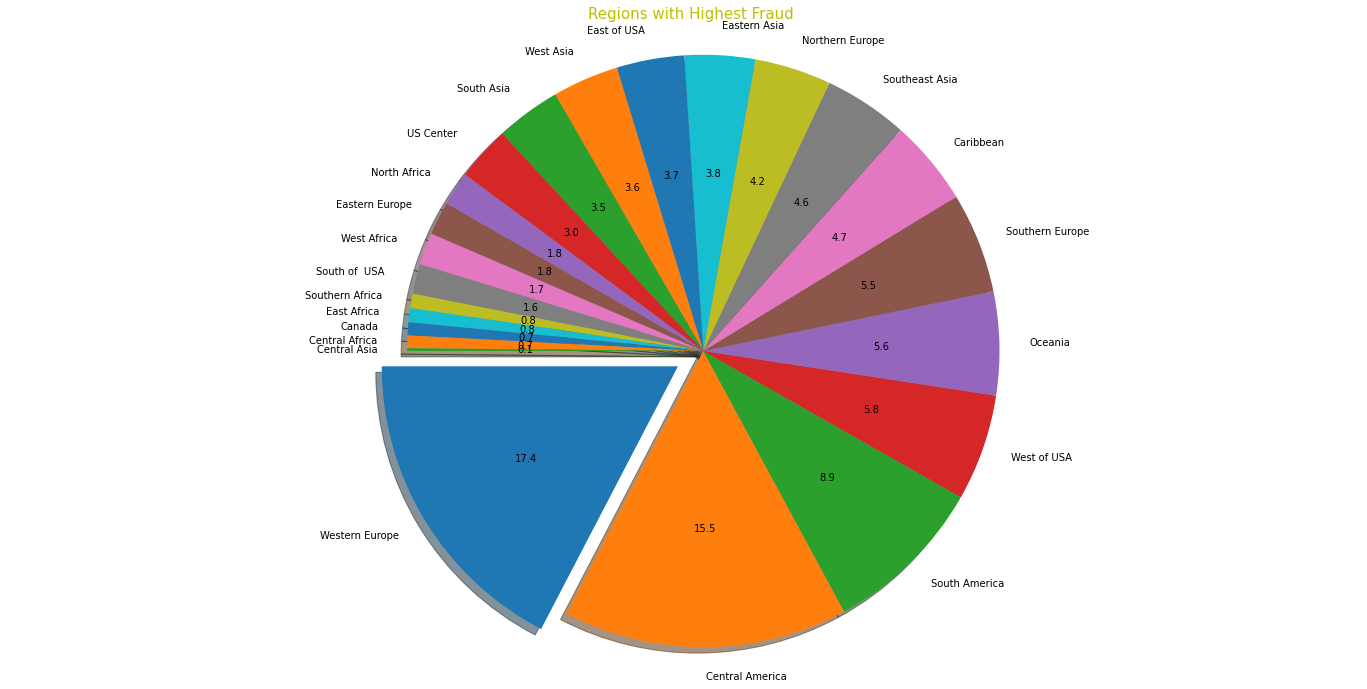

In [ ]:
high_fraud = data[(data['Order Status'] == 'SUSPECTED_FRAUD') & (data['Type'] == 'TRANSFER')]#separating orders with suspected fraud
#Plotting pie chart with respect to order region
fraud=high_fraud['Order Region'].value_counts().plot.pie(figsize=(24,12),
                                                  startangle=180, explode=(0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0),autopct='%.1f',shadow=True,)
plt.title("Regions with Highest Fraud",size=15,color='y') # Plotting title
plt.ylabel(" ")
fraud.axis('equal') 
plt.show()

It can be observed that highest number of suspected fraud orders are from Western Europe which is approximately 17.4% of total orders followed by Central America with 15.5%. 

Which product is being suspected fraud the most?

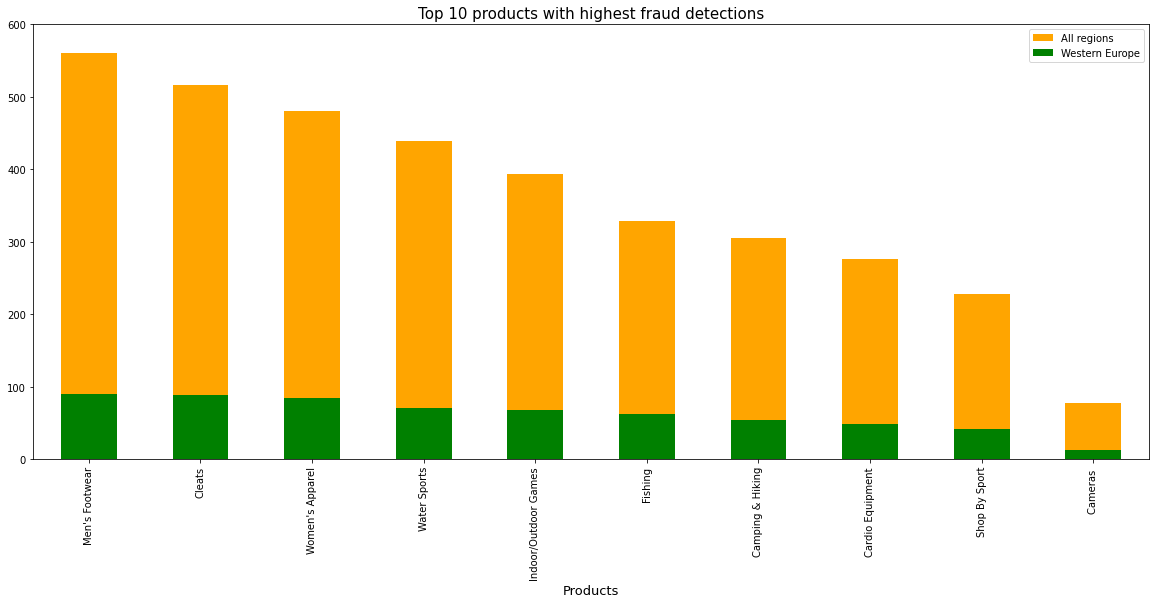

In [ ]:
high_fraud1 = data[(data['Order Status'] == 'SUSPECTED_FRAUD')] # 
high_fraud2 = data[(data['Order Status'] == 'SUSPECTED_FRAUD') &(data['Order Region'] == 'Western Europe')]
#Plotting bar chart for top 10 most suspected fraud department in all regions
fraud1=high_fraud1['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Fraud Category",color='orange')
#Plotting bar chart for top 10 most suspected fraud department in Western Europe
fraud2=high_fraud2['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Fraud product in Western Europe",color='green')
plt.legend(["All regions", "Western Europe"])
plt.title("Top 10 products with highest fraud detections", size=15)
plt.xlabel("Products", size=13)
plt.ylim(0,600)
plt.show()

It is very suprising to see that cleats department is being suspected to fraud the most followed by Men's footwear in all the regions and also in Western Europe.

Which customers are conducting all these fraud?

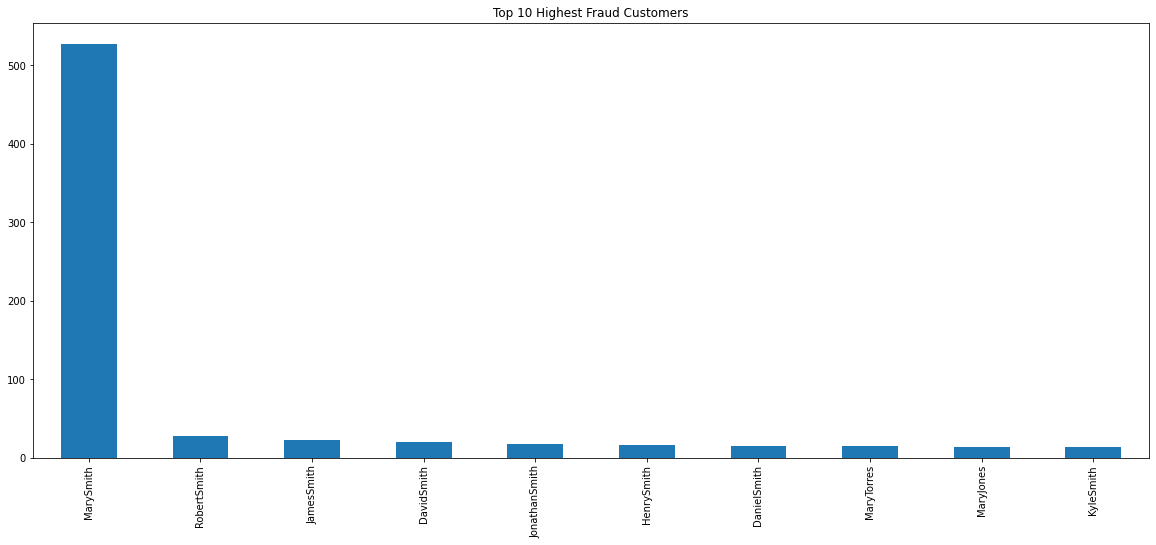

In [ ]:
#Filtering out suspected fruad orders
cus = data[(data['Order Status'] == 'SUSPECTED_FRAUD')] 
#Top 10 customers with most fraud
cus['Customer Full Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Top 10 Highest Fraud Customers")

The customer named Mary Smith alone was responible for trying to conduct fraud 528 times which is very shocking 


**Delivering products to customer on time without late delivery is another important aspect for a supply chain company because customers will not be satisfied if products are not delivered on time.**


 What  category of products are being delivered late the most?

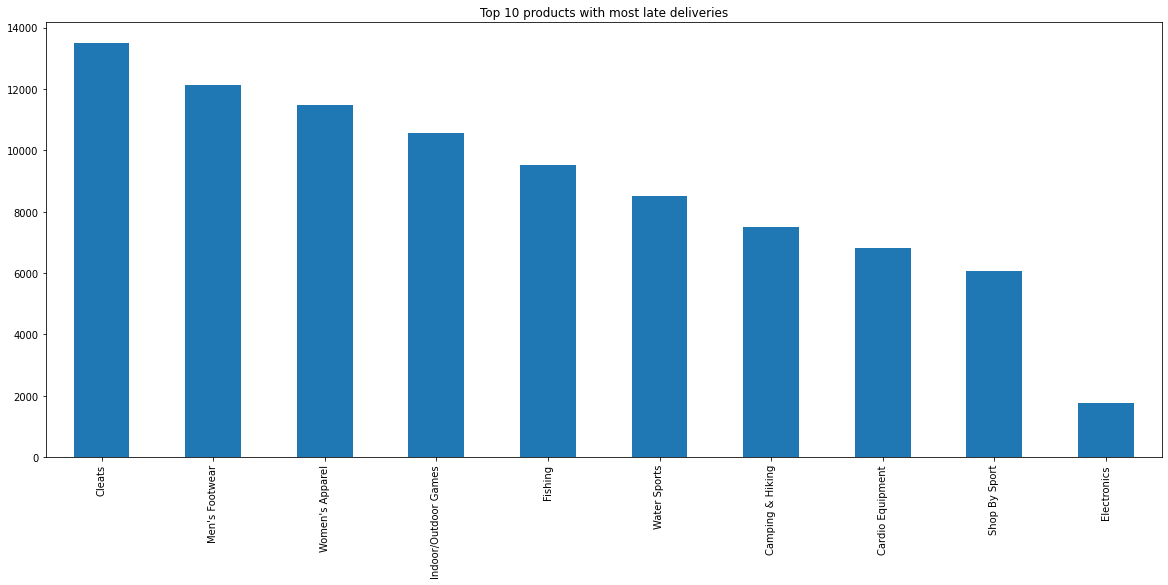

In [ ]:
#Filtering columns with late delivery status
late_delivery = data[(data['Delivery Status'] == 'Late delivery')]
#Top 10 products with most late deliveries
late_delivery['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Top 10 products with most late deliveries")


It can be seen that orders with Cleats department is getting delayed the most followed by Men's Footwear.For some orders risk of late delivery is given in data.

The products with late delivery risk are compared with late delivered products. 

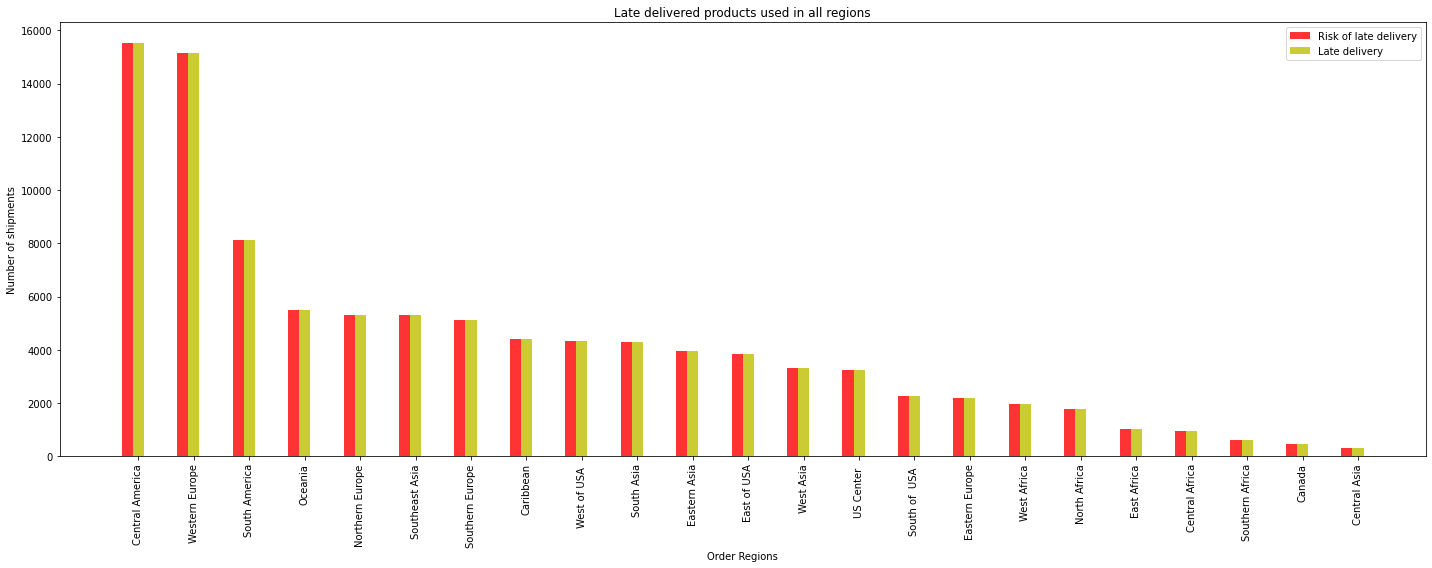

In [ ]:
#Filtering orders with late delivery risk
xyz1 = data[(data['Late_delivery_risk'] == 1)]
#Filtering late delivered orders
xyz2 = data[(data['Delivery Status'] == 'Late delivery')]
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
#Index names
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8)) #Figure size
index=np.arange(n_groups)
bar_width=0.2
opacity=0.8
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='r',label='Risk of late delivery')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='y',label='Late delivery')
plt.xlabel('Order Regions')
plt.ylabel('Number of shipments')
plt.title('Late delivered products used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()


Thus,it can be concluded that for all the products with late delivery risk irrespective of region the product is actually being delivered late,to avoid late delivery the company can ship products faster using better shipping method or schedule more time of Days for shipment so customers will know in advance when the products will reach them. It will be interesting to see the number of late deliveried orders for different types of shipment method in all regions.

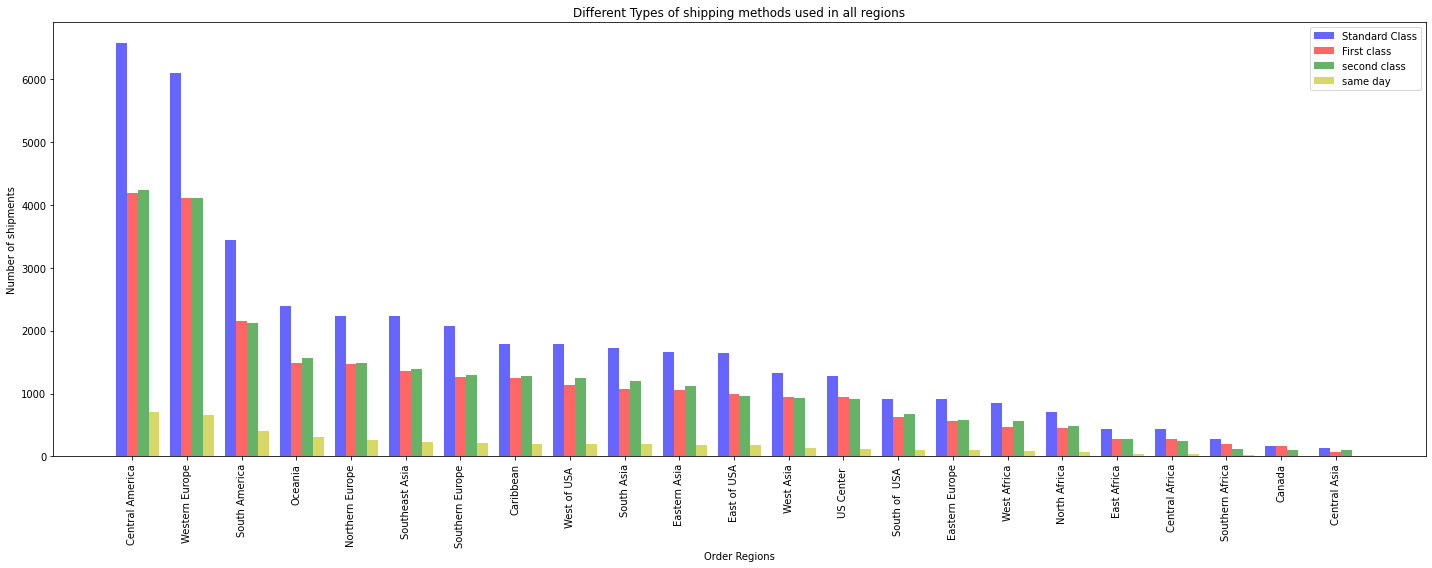

In [ ]:
#Filtering late delivery orders with standard class shipping
xyz1 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Standard Class')]
#Filtering late delivery orders with first class shipping
xyz2 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'First Class')]
#Filtering late delivery orders with second class shipping
xyz3 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Second Class')]
#Filtering late delivery orders with same day shipping
xyz4 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Same Day')]
#Counting total values
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
count3=xyz3['Order Region'].value_counts()
count4=xyz4['Order Region'].value_counts()
#Index names
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='b',label='Standard Class')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='First class')
type3=plt.bar(index+bar_width+bar_width,count3,bar_width,alpha=opacity,color='g',label='second class')
type4=plt.bar(index+bar_width+bar_width+bar_width,count4,bar_width,alpha=opacity,color='y',label='same day')
plt.xlabel('Order Regions')
plt.ylabel('Number of shipments')
plt.title('Different Types of shipping methods used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

As expected the most number of late deliveries  for all regions occured with standard class shipping,with same day shipping being the one with least number of late deliveries.Both the first class and second class shipping have almost equal number of late deliveries.

# Data Modelling

To measure the performance of different models the machine learning models are trained to detect fraud,late delivery for classification type. And sales, order quantity is predicted for regression type models.

A new dataset is created with the copy of original data for training the data and validation.

In [ ]:
train_data=data.copy()

Two new columns are created for orders with suspected fraud and late delivery making them into binary classification, which in turn helps to measure performance of different models better.

In [ ]:
train_data['fraud'] = np.where(train_data['Order Status'] == 'SUSPECTED_FRAUD', 1, 0)
train_data['late_delivery']=np.where(train_data['Delivery Status'] == 'Late delivery', 1, 0)

Now to measure machine models accurately all the columns with repeated values are dropped like late_delivery_risk column because, it is known all the products with late delivery risk are delivered late. And Order Status column because, a new column for fraud detection is created there is a chance machine learning model might take values directly from these columns to predict output.

In [ ]:
#Dropping columns with repeated values
train_data.drop(['Delivery Status','Late_delivery_risk','Order Status','order_month_year','order date (DateOrders)'], axis=1, inplace=True)

It is important to check the type of variables in the data because machine learning models can only be trained with numerical values.

In [ ]:
train_data.dtypes

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Category Id                        int64
Category Name                     object
Customer City                     object
Customer Country                  object
Customer Id                        int64
Customer Segment                  object
Customer State                    object
Customer Zipcode                 float64
Department Id                      int64
Department Name                   object
Market                            object
Order City                        object
Order Country                     object
Order Customer Id                  int64
Order Id                           int64
Order Item Cardprod Id             int64
Order Item Discount              float64
Order Item Discount Rate         float64
Order Item Id                      int64
Order Item Produ

There are some columns with object type data which cannot be trained in machine learning models so all the object type data is converted to int type using preprocessing label encoder library.

In [ ]:
# create the Labelencoder object
le = preprocessing.LabelEncoder()
#convert the categorical columns into numeric
train_data['Customer Country']  = le.fit_transform(train_data['Customer Country'])
train_data['Market']            = le.fit_transform(train_data['Market'])
train_data['Type']              = le.fit_transform(train_data['Type'])
train_data['Product Name']      = le.fit_transform(train_data['Product Name'])
train_data['Customer Segment']  = le.fit_transform(train_data['Customer Segment'])
train_data['Customer State']    = le.fit_transform(train_data['Customer State'])
train_data['Order Region']      = le.fit_transform(train_data['Order Region'])
train_data['Order City']        = le.fit_transform(train_data['Order City'])
train_data['Category Name']     = le.fit_transform(train_data['Category Name'])
train_data['Customer City']     = le.fit_transform(train_data['Customer City'])
train_data['Department Name']   = le.fit_transform(train_data['Department Name'])
train_data['Order State']       = le.fit_transform(train_data['Order State'])
train_data['Shipping Mode']     = le.fit_transform(train_data['Shipping Mode'])
train_data['order_week_day']    = le.fit_transform(train_data['order_week_day'])
train_data['Order Country']     = le.fit_transform(train_data['Order Country'])
train_data['Customer Full Name']= le.fit_transform(train_data['Customer Full Name'])

#display the initial records
train_data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Category Id,Category Name,Customer City,Customer Country,Customer Id,Customer Segment,Customer State,Customer Zipcode,Department Id,Department Name,Market,Order City,Order Country,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Product Card Id,Product Category Id,Product Name,Product Price,Shipping Mode,Customer Full Name,order_year,order_month,order_week_day,order_hour,fraud,late_delivery
0,1,3,4,91.250000,314.640015,73,40,66,1,20755,0,36,725.0,2,4,3,331,70,20755,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,15,475,1360,73,78,327.75,3,1876,2018,1,2,22,0,0
1,3,5,4,-249.089996,311.359985,73,40,66,1,19492,0,36,725.0,2,4,3,391,69,19492,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,13,841,1360,73,78,327.75,3,5378,2018,1,5,12,0,1
2,0,4,4,-247.779999,309.720001,73,40,452,0,19491,0,5,95125.0,2,4,3,391,69,19491,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,13,841,1360,73,78,327.75,3,4429,2018,1,5,12,0,0
3,1,3,4,22.860001,304.809998,73,40,285,0,19490,2,5,90027.0,2,4,3,3226,8,19490,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,11,835,1360,73,78,327.75,3,12929,2018,1,5,11,0,0
4,2,2,4,134.210007,298.250000,73,40,66,1,19489,1,36,725.0,2,4,3,3226,8,19489,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,11,835,1360,73,78,327.75,3,10638,2018,1,5,11,0,0


Now all the data is transformed into int type. The dataset is split into train data and test data so model can be trained with train data and the performance of model can be evaluated using test data.

## Machine Learning Models

In [ ]:
#All columns expect fraud
xf=train_data.loc[:, train_data.columns != 'fraud']
#Only fraud column
yf=train_data['fraud']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
xf_train, xf_test,yf_train,yf_test = train_test_split(xf,yf,test_size = 0.2,random_state = 42)
#All columns expect fraud
xl=train_data.loc[:, train_data.columns != 'late_delivery']
#Only fraud column
yl=train_data['late_delivery']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
xl_train, xl_test,yl_train,yl_test = train_test_split(xl,yl,test_size = 0.2, random_state = 42)

Since there are so many different variables with different ranges standard scaler is used to standardize total the data so it is internally consistent before training the data with machine learning.

In [ ]:
sc = StandardScaler()
xf_train=sc.fit_transform(xf_train)
xf_test=sc.transform(xf_test)
xl_train=sc.fit_transform(xl_train)
xl_test=sc.transform(xl_test)

The data is now ready to be used in machine learning models since many different models are compared training every model from begining is complicated so a function is defined to make the process bit easy. The output is in binary classification format so all the models are measured with Accuracy score,recall score and F1 score metrics. 

To measure the performance of different models F1 score is used as the main metric because it is the harmonic mean of precison score and recall score.And all the scores are multiplied with 100 for better understanding

In [ ]:
def classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test):
    model_f=model_f.fit(xf_train,yf_train) # Fitting train data for fraud detection
    model_l=model_l.fit(xl_train,yl_train) # Fitting train data for predection of late delivery
    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)  
    accuracy_f=accuracy_score(yf_pred, yf_test) #Accuracy for fraud detection
    accuracy_l=accuracy_score(yl_pred, yl_test) #Accuracy for predection of late delivery
    recall_f=recall_score(yf_pred, yf_test) #Recall score for  fraud detection
    recall_l=recall_score(yl_pred, yl_test)# Recall score for predection of late delivery
    conf_f=confusion_matrix(yf_test, yf_pred)# fraud detection
    conf_l=confusion_matrix(yl_test, yl_pred)#predection of late delivery
    f1_f=f1_score(yf_test, yf_pred)#fraud detection
    f1_l=f1_score(yl_test, yl_pred)#predection of late delivery
    print('Model paramters used are :',model_f)
    print('Accuracy of fraud status is        :', (accuracy_f)*100,'%')
    print('Recall score of fraud status is        :', (recall_f)*100,'%')
    print('Conf Matrix of fraud status is        :\n',  (conf_f))
    print('F1 score of fraud status is        :', (f1_f)*100,'%')
    print('Accuracy of late delivery status is:', (accuracy_l)*100,'%')
    print('Recall score of late delivery status is:', (recall_l)*100,'%')
    print('Conf Matrix of late delivery status is: \n',(conf_l))
    print('F1 score of late delivery status is:', (f1_l)*100,'%')

###Logistic regression model

In [ ]:
model_f = LogisticRegression(solver='lbfgs',random_state=0) #the classification model
model_l = LogisticRegression(solver='lbfgs',random_state=0) #the classification model
#Giving inputs to the defined function
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

Model paramters used are : LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy of fraud status is        : 97.78140926213162 %
Recall score of fraud status is        : 57.98045602605863 %
Conf Matrix of fraud status is        :
 [[35125   129]
 [  672   178]]
F1 score of fraud status is        : 30.769230769230766 %
Accuracy of late delivery status is: 98.84777309993352 %
Recall score of late delivery status is: 97.9419185672587 %
Conf Matrix of late delivery status is: 
 [[15891   416]
 [    0 19797]]
F1 score of late delivery status is: 98.96025993501625 %


### K nearest Neighbors classification

In [ ]:
model_f = KNeighborsClassifier(n_neighbors=1)
model_l = KNeighborsClassifier(n_neighbors=1)
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

Model paramters used are : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
Accuracy of fraud status is        : 97.41025925105251 %
Recall score of fraud status is        : 43.390357698289264 %
Conf Matrix of fraud status is        :
 [[34890   364]
 [  571   279]]
F1 score of fraud status is        : 37.374413931681175 %
Accuracy of late delivery status is: 80.9522490582761 %
Recall score of late delivery status is: 83.45763414128858 %
Conf Matrix of late delivery status is: 
 [[13113  3194]
 [ 3683 16114]]
F1 score of late delivery status is: 82.41401355325407 %


### Random forest classification

In [ ]:
model_f = RandomForestClassifier()
model_l = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

Model paramters used are : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy of fraud status is        : 98.74252160425438 %
Recall score of fraud status is        : 97.36842105263158 %
Conf Matrix of fraud status is        :
 [[35243    11]
 [  443   407]]
F1 score of fraud status is        : 64.1955835962145 %
Accuracy of late delivery status is: 98.60126301794814 %
Recall score of late delivery status is: 97.51256033888286 %
Conf Matrix of late delivery status is: 
 [[15802   505]
 [   

### Decision tree classification

In [ ]:
model_f = tree.DecisionTreeClassifier()
model_l = tree.DecisionTreeClassifier()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)


Model paramters used are : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy of fraud status is        : 99.11367161533347 %
Recall score of fraud status is        : 81.77458033573141 %
Conf Matrix of fraud status is        :
 [[35102   152]
 [  168   682]]
F1 score of fraud status is        : 80.99762470308788 %
Accuracy of late delivery status is: 99.42665632616885 %
Recall score of late delivery status is: 99.444724886421 %
Conf Matrix of late delivery status is: 
 [[16197   110]
 [   97 19700]]
F1 score of late delivery status is: 99.47736511222762 %


For better understanding and comparision of all the scores a dataframe is created

In [ ]:
#Giving column Values
classification_data = {'Classification Model':  ['Logistic regression','K nearest Neighbour','Random Forest','Decision tree'],
        'Accuracy Score for Fraud Detection':     [97.80,97.36,98.48,99.12],
        'Recall Score for Fraud Detection':       [59.40,41.90,93.18,82.53],
        'F1 Score for Fraud Detection':           [31.22,35.67,54.57,81.00],
        'Accuracy Score for Late Delivery':       [98.84,80.82,98.60,99.37],
        'Recall Score for Late Delivery':         [97.94,83.45,97.52,99.44],
        'F1 Score for Late Delivery':             [98.96,82.26,98.74,99.42] }
#Creating data frame with Column Names
classification_comparision = pd.DataFrame (classification_data, columns = ['Classification Model','Accuracy Score for Fraud Detection','Recall Score for Fraud Detection','F1 Score for Fraud Detection',
                                                                           'Accuracy Score for Late Delivery','Recall Score for Late Delivery','F1 Score for Late Delivery'])


### Comparision Table for Classification Scores

In [ ]:
classification_comparision #Printing dataframe

,Classification Model,Accuracy Score for Fraud Detection,Recall Score for Fraud Detection,F1 Score for Fraud Detection,Accuracy Score for Late Delivery,Recall Score for Late Delivery,F1 Score for Late Delivery
0,Logistic regression,97.80,59.40,31.22,98.84,97.94,98.96
1,K nearest Neighbour,97.36,41.90,35.67,80.82,83.45,82.26
2,Random Forest,98.48,93.18,54.57,98.60,97.52,98.74
3,Decision tree,99.12,82.53,81.00,99.37,99.44,99.42


In [ ]:
classification_comparision.max() #Checking max values in every column

Classification Model                  eExtreme gradient boosting
Accuracy Score for Fraud Detection                         99.12
Recall Score for Fraud Detection                           98.88
F1 Score for Fraud Detection                                  81
Accuracy Score for Late Delivery                           99.37
Recall Score for Late Delivery                             99.44
F1 Score for Late Delivery                                 99.42
dtype: object

Considering F1 score it is clear that Decision Tree classifier is performing better for classification type with F1 score of almost 80% for fraud detection and 99.42% for late delivery.Suprisingly, all the models predicted the late delivery of orders with almost 98% accuracy.